In [86]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
sns.set_context('notebook')
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns=None
pd.options.display.max_rows=None
np.set_printoptions(threshold=np.inf)

In [87]:
import forecast
import copy
sns.set_style('ticks')
red='#D62728'
blue='#1F7784'
%matplotlib inline

In [88]:
dateparser=lambda x:pd.datetime.strptime(x,'%b-%y')
d=pd.read_csv('Visitors.csv',index_col='Date',date_parser=dateparser)

## EDA

In [89]:
d.describe().round(4)

,Number of Visitors
count,312.0000
mean,419407.3718
std,132443.0593
min,161400.0000
25%,332625.0000
50%,412950.0000
75%,488775.0000
max,971800.0000


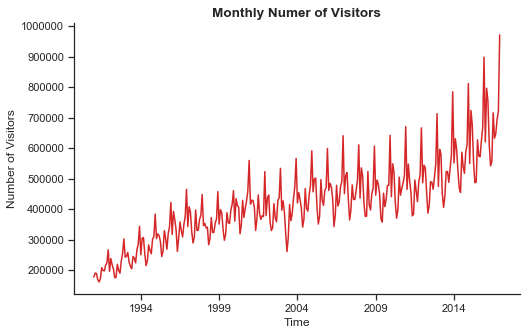

In [90]:
y=d['Number of Visitors'].copy()
fig,ax=plt.subplots(figsize=(8,5))
y.plot(color=red)
ax.set_xlabel('Time')
ax.set_ylabel('Number of Visitors')
ax.set_title('Monthly Numer of Visitors',fontsize=13.5,fontdict=dict(weight='bold'))
ax.set_xticks([],minor=True)
sns.despine()
plt.show()

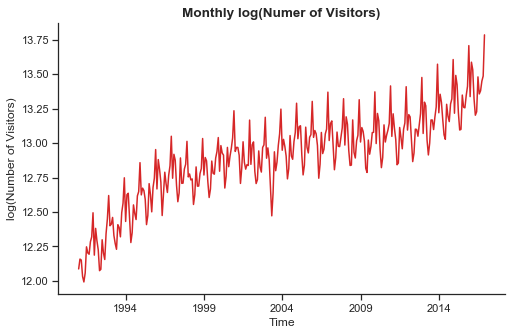

In [91]:
#EDA
fig,ax=plt.subplots(figsize=(8,5))
np.log(y).plot(color=red)
ax.set_xlabel('Time')
ax.set_ylabel('log(Number of Visitors)')
ax.set_title('Monthly log(Numer of Visitors)',fontsize=13.5,fontdict=dict(weight='bold'))
ax.set_xticks([],minor=True)
sns.despine()
plt.show()

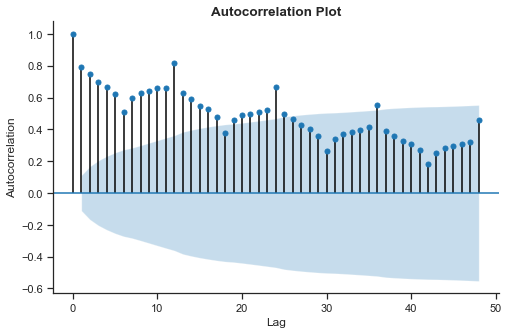

In [92]:
fig,ax=plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(y,lags=48,ax=ax)
sns.despine()
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
plt.title('Autocorrelation Plot',fontsize=13.5,fontdict=dict(weight='bold'))
plt.show()

Text(0, 0.5, 'Resid')

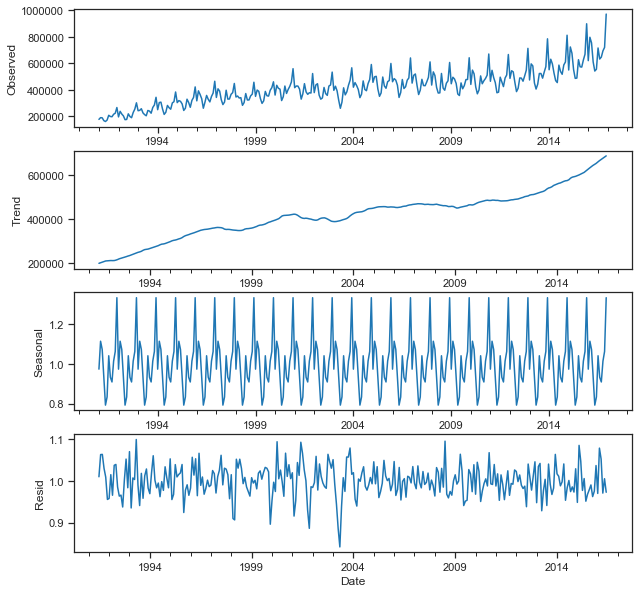

In [93]:
basic_decomposition=sm.tsa.seasonal_decompose(y,model='multiplicative')
fig,(ax0,ax1,ax2,ax3)=plt.subplots(4,1,figsize=(10,10))
basic_decomposition.observed.plot(ax=ax0,label='Observed')
basic_decomposition.trend.plot(ax=ax1)
basic_decomposition.seasonal.plot(ax=ax2)
basic_decomposition.resid.plot(ax=ax3)
ax0.set_ylabel('Observed')
ax1.set_ylabel('Trend')
ax2.set_ylabel('Seasonal')
ax3.set_ylabel('Resid')
#residual 比较random

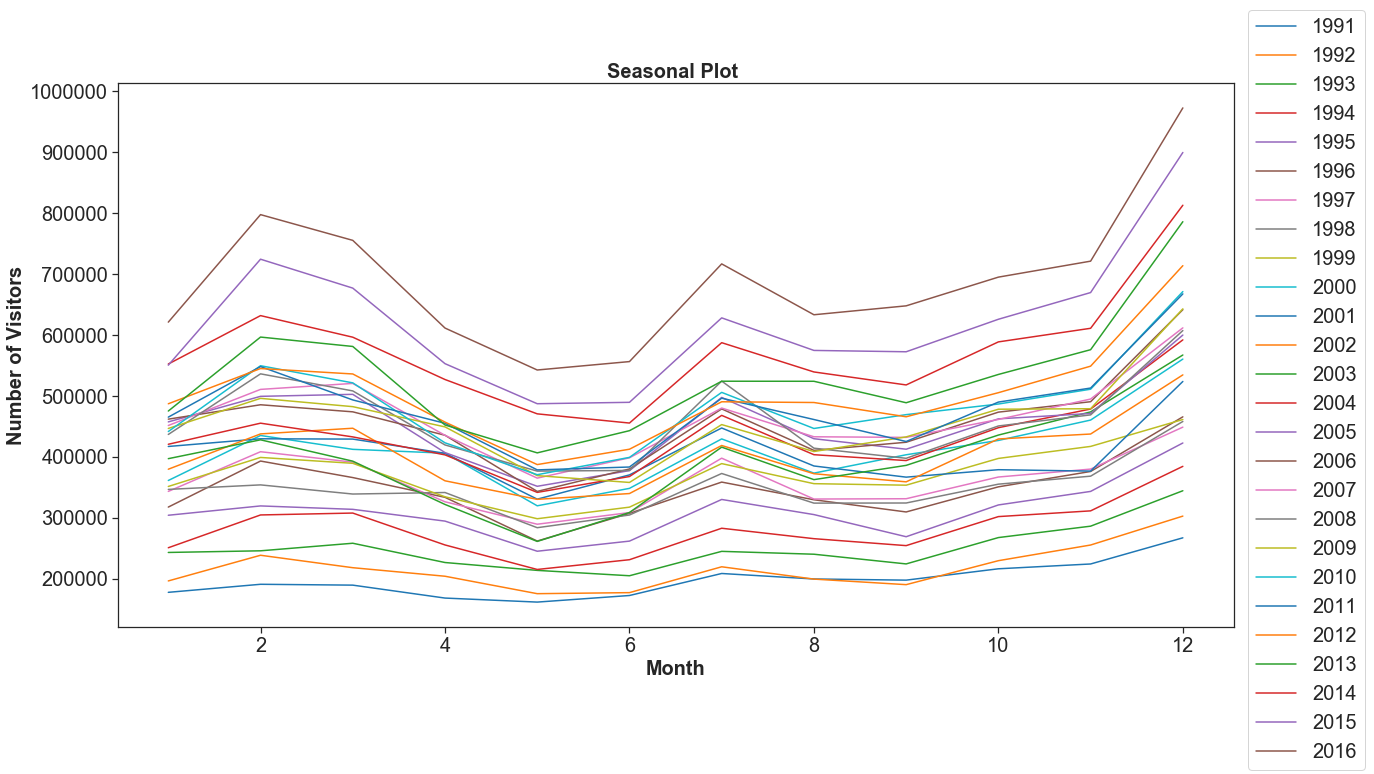

In [94]:
#this code is based on
#https://deffro.github.io/time%20series/exploratory%20data%20analysis/data%20visualization/time-series-analysis/
#https://otexts.com/fpp2/seasonal-plots.html

d['year']=[d.year for d in d.index]
d['month']=[d.month for d in d.index]
years=d['year'].unique()
fig,ax=plt.subplots(figsize=(20,10))
for i in years:
    subset=d[d['year']==i]
    plt.plot(subset['month'],subset['Number of Visitors'],label=i)
ax.set_title('Seasonal Plot ',fontsize=20,fontdict=dict(weight='bold'))
ax.set_xlabel('Month',fontsize=20,fontdict=dict(weight='bold'))
ax.set_ylabel('Number of Visitors',fontsize=20,fontdict=dict(weight='bold'))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.legend(fontsize=20)

<Figure size 2000x1000 with 0 Axes>

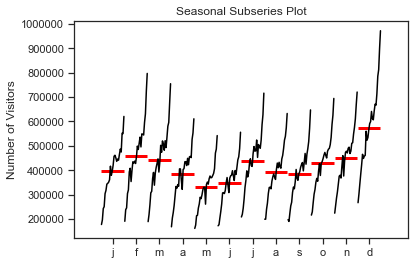

In [95]:
#the following code is from
#https://deffro.github.io/time%20series/exploratory%20data%20analysis/data%20visualization/time-series-analysis/
#https://otexts.com/fpp2/seasonal-subseries-plots.html

from statsmodels.graphics.tsaplots import month_plot
plt.figure(figsize=(20,10),dpi=100)
month_plot(d['Number of Visitors'],ylabel='Number of Visitors')
plt.title('Seasonal Subseries Plot')
plt.show()

## Models

### Seasonal random walk

In [96]:
#seasonal random walk
srw_fitted=y.copy()
for i in range(12,len(y)):
    srw_fitted.iloc[i]=y.iloc[i-12]
srw_resid=(y-srw_fitted)[12:]

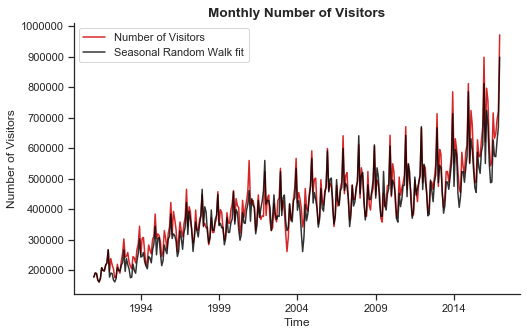

In [97]:
fig,ax=plt.subplots(figsize=(8,5))
y.plot(color=red,label='Number of Visitors')
srw_fitted.plot(color='black',label='Seasonal Random Walk fit',alpha=0.8)
ax.set_xlabel('Time')
ax.set_ylabel('Number of Visitors')
ax.set_title('Monthly Number of Visitors',fontsize=13.5,fontdict=dict(weight='bold'))
ax.set_xticks([],minor=True)
plt.legend(loc='best')
sns.despine()
plt.show()

### Additive Holt-winters exponential smoothing

In [98]:
ahw=forecast.holtwinters(y, additive=True, damped=False, m=12)
ahw.fit()
ahw.summary()

 Additive Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.259 (0.040)
 beta  (trend)    0.024 (0.019)
 delta (seasonal) 0.582 (0.064)
 
 In-sample fit:
 MSE               475476792.239
 RMSE              21805.430
 Log-likelihood   -3559.562
 AIC               7127.124
 BIC               7142.096


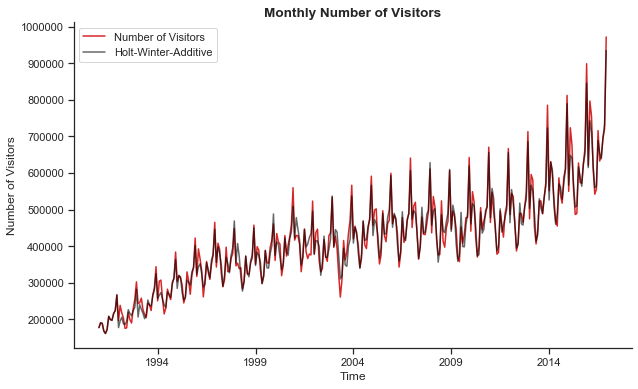

In [99]:
smoothed=pd.Series(ahw.smooth(), index=y.index)

fig, ax= plt.subplots(figsize=(10,6))

y.plot(color='#D62728', label='Number of Visitors')
smoothed.plot(color='black', label='Holt-Winter-Additive', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('Number of Visitors')
ax.set_xticks([], minor=True)
ax.set_title(r'Monthly Number of Visitors', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

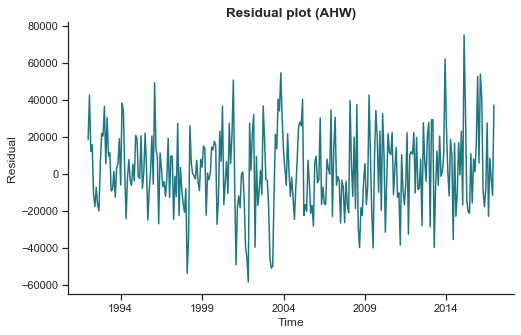

In [100]:
ahw_resid = (y-ahw.smooth())[12:] # we remove the first 12 observations as they are for initialisitation only

fig, ax= plt.subplots(figsize=(8,5))
ahw_resid.plot(color=blue)
ax.set_xlabel('Time')
ax.set_ylabel('Residual')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot (AHW)',fontsize=13.5,fontweight='bold')
sns.despine()
plt.show()

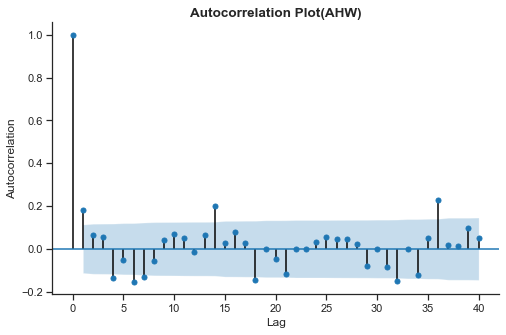

In [101]:
fig,ax=plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(ahw_resid,lags=40,ax=ax)
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
plt.title('Autocorrelation Plot(AHW)',fontsize=13.5,fontweight='bold')
sns.despine()
plt.show()

### Multiplicative Holt-winters exponential smoothing

In [102]:
mhw=forecast.holtwinters(y, additive=False, damped=False, m=12)
mhw.fit()
mhw.summary()

 Multiplicative Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.310 (0.078)
 beta  (trend)    0.012 (0.008)
 delta (seasonal) 0.362 (0.050)
 
 In-sample fit:
 MSE               434674481.526
 RMSE              20848.848
 Log-likelihood   -3545.566
 AIC               7099.131
 BIC               7114.103


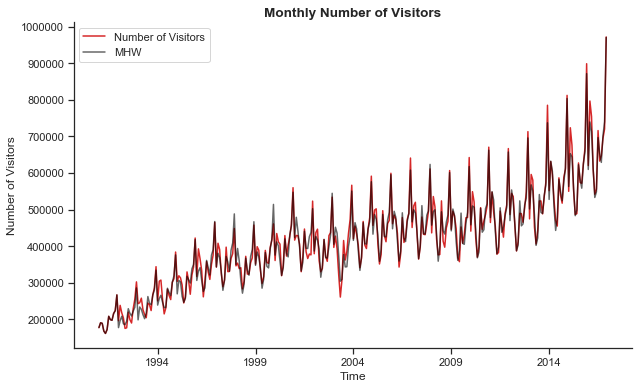

In [121]:
smoothed=pd.Series(mhw.smooth(), index=y.index)

fig, ax= plt.subplots(figsize=(10,6))

y.plot(color='#D62728', label='Number of Visitors')
smoothed.plot(color='black', label='MHW', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('Number of Visitors')
ax.set_xticks([], minor=True)
ax.set_title(r'Monthly Number of Visitors', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

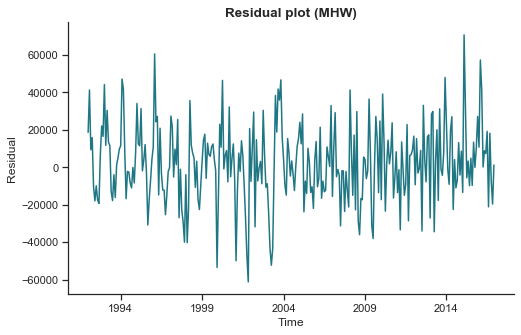

In [104]:
mhw_resid = (y-mhw.smooth())[12:] # we remove the first 12 observations as they are for initialisitation only

fig, ax= plt.subplots(figsize=(8,5))
mhw_resid.plot(color=blue)
ax.set_xlabel('Time')
ax.set_ylabel('Residual')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot (MHW)',fontsize=13.5,fontweight='bold')
sns.despine()
plt.show()

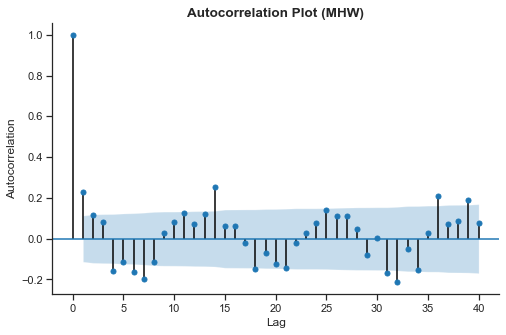

In [122]:
fig,ax=plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(mhw_resid,lags=40,ax=ax)
ax.set_ylabel('Autocorrelation')
ax.set_xlabel('Lag')
plt.title('Autocorrelation Plot (MHW)',fontsize=13.5,fontweight='bold')
sns.despine()
plt.show()

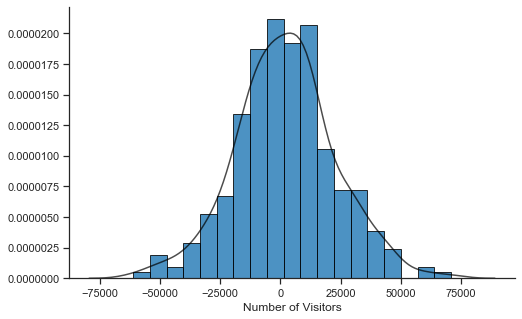

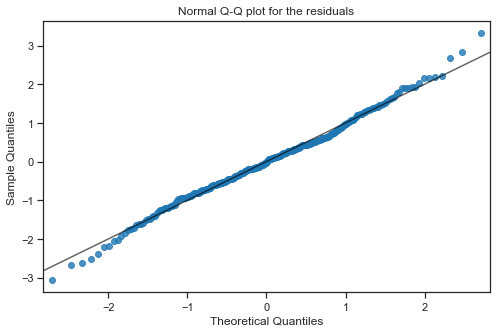

Residual skewness: 0.059
Residual kurtosis: 0.509


In [106]:
from forecast import histogram, qq_plot

histogram(mhw_resid)
plt.show()

qq_plot(mhw_resid)
plt.show()

print('Residual skewness: {:.3f}'.format(mhw_resid.skew()))
print('Residual kurtosis: {:.3f}'.format(mhw_resid.kurt()))

 ### Additive Holt-winters exponential smoothing (for log number)

In [107]:
ahw_log=forecast.holtwinters(np.log(y),additive=True,damped=False,m=12)
ahw_log.fit()
ahw_log_resid_0=(np.log(y)-ahw_log.smooth())[12:]
ahw_log_fitted=pd.Series(np.exp(ahw_log.smooth())*np.mean(np.exp(ahw_log_resid_0)),index=y.index)
ahw_log_resid=(y-ahw_log_fitted)[12:]
ahw_log.summary()

 Additive Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.300 (0.052)
 beta  (trend)    0.009 (0.007)
 delta (seasonal) 0.426 (0.074)
 
 In-sample fit:
 MSE               0.003
 RMSE              0.054
 Log-likelihood    465.889
 AIC               -923.778
 BIC               -908.806


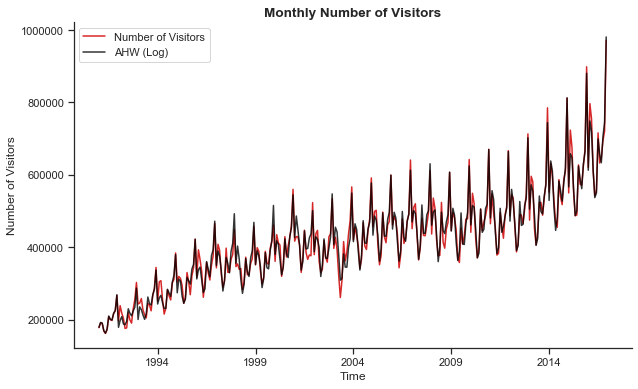

In [108]:
fig,ax=plt.subplots(figsize=(10,6))
y.plot(color=red,label='Number of Visitors')
ahw_log_fitted.plot(color='black',label='AHW (Log)',alpha=0.8)
ax.set_xlabel('Time')
ax.set_ylabel('Number of Visitors')
ax.set_title('Monthly Number of Visitors',fontsize=13.5,fontweight='bold')
ax.set_xticks([],minor=True)
plt.legend(loc='best')
sns.despine()
plt.show()

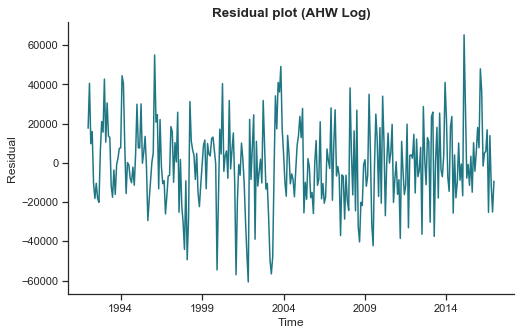

In [109]:
fig, ax= plt.subplots(figsize=(8,5))
ahw_log_resid.plot(color=blue)
ax.set_xlabel('Time')
ax.set_ylabel('Residual')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot (AHW Log)',fontsize=13.5,fontweight='bold')
sns.despine()
plt.show()

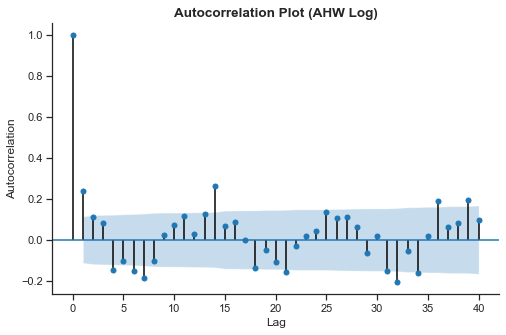

In [110]:
fig,ax=plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(ahw_log_resid,lags=40,ax=ax)
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
plt.title('Autocorrelation Plot (AHW Log)',fontsize=13.5,fontweight='bold')
sns.despine()
plt.show()

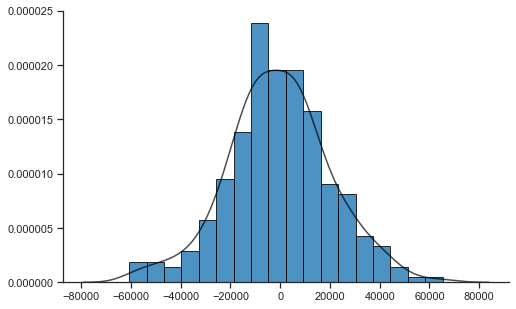

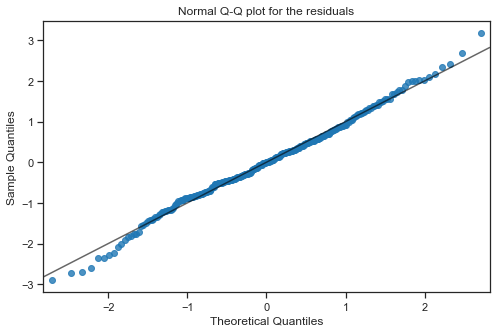

Residual skewness: -0.017
Residual kurtosis: 0.409


In [111]:
from forecast import histogram, qq_plot

histogram(ahw_log_resid)
plt.show()

qq_plot(ahw_log_resid)
plt.show()

print('Residual skewness: {:.3f}'.format(ahw_log_resid.skew()))
print('Residual kurtosis: {:.3f}'.format(ahw_log_resid.kurt()))

## Real time forecasting 

In [112]:
y = d['Number of Visitors'].copy()
y.index = y.index.to_period(freq='M')

#ts = data['Turnover']

ts=np.log(y) # log series for the log-additive model

validation=y['2012-01':].index
start = y.index.get_loc('2012-01') 

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # mutiplicative holt winters
pred5 = [] # log additive holt winters
actual= []

for i in range(start, len(y)):  
    actual.append(y.iloc[i]) # actual value   
    pred1.append(y.iloc[i-12]) # seasonal random walk forecast
    
    model2 = forecast.holtwinters(y.iloc[:i], additive=True, damped=False, m=12)
    model2.fit()
    pred2.append(model2.forecast(1)[0]) # additive holt winters forecast
    
    model3 = forecast.holtwinters(y.iloc[:i], additive=False, damped=False, m=12)
    model3.fit()
    pred3.append(model3.forecast(1)[0]) # multiplicate holt winters forecast
    
    
    model5 = forecast.holtwinters(ts.iloc[:i], additive=True, damped=False, m=12)
    model5.fit()
    resid5 = (ts.iloc[:i]-model5.smooth())[12:] # residuals
    y_pred5 = np.exp(model5.forecast(1)[0])*np.mean(np.exp(resid5)) # forecast with a retransformation adjustment 
    pred5.append(y_pred5) # long additive holt winters forecast

In [113]:
columns=['Seasonal RW', 'Additive', 'Multiplicative', 'Log additive', 'Actual']
results = np.vstack([pred1,pred2,pred3,pred5,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

In [114]:
from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(4):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(4)

,RMSE,SE
Seasonal RW,49114.1578,3049.6018
Additive,31970.8742,3741.8026
Multiplicative,25815.8980,3372.7052
Log additive,23705.4416,3032.1088


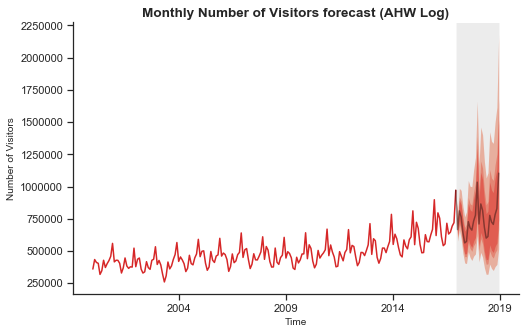

In [115]:
h=24

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='M')

pred=pd.Series(ahw_log.forecast(h), index=test)
var = ahw_log.forecastvariance(h)
pred=np.exp(pred+var/2) # retransformation under the assumption of normality, for simplicity

intv1=pd.DataFrame(ahw_log.intervalforecast(h, level=.8), index=test)
intv2=pd.DataFrame(ahw_log.intervalforecast(h, level=.9), index=test)
intv3=pd.DataFrame(ahw_log.intervalforecast(h, level=.99), index=test)
intv1=np.exp(intv1)
intv2=np.exp(intv2)
intv3=np.exp(intv3)

fig, ax = forecast.fanchart(y['01-2000':], pred, intv1, intv2, intv3)

ax.set_xticks([], minor=True)
ax.set_xlabel('Time',fontsize=10)
ax.set_ylabel('Number of Visitors',fontsize=10)
plt.title('Monthly Number of Visitors forecast (AHW Log)', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

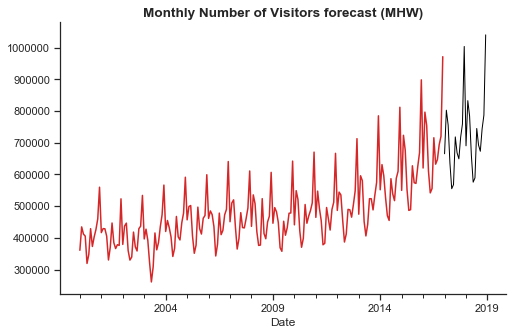

In [116]:
#forecast results
h=24
test=pd.period_range(start=y.index[-1]+1,periods=h,freq='M')
pred_mhw=pd.Series(mhw.forecast(h),index=test)
fig=plt.figure(figsize=(8,5))

y['01-2000':].plot(color=red)
pred_mhw.plot(linewidth=1,color='black')

ax.set_xticks([], minor=True)
ax.set_xlabel('Time',fontsize=10)
ax.set_ylabel('Number of Visitors',fontsize=10)
plt.title('Monthly Number of Visitors forecast (MHW)', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

#mhw doesn't allow period h=24 larger than frequence m=12